## **Evaluating Various Statistics from the NBA**

Project by Wyatt Riker

# **Spring 2024 Data Science Project**

Wyatt Riker, Contribution: 100%

I, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.

-Wyatt Riker 5/7/24

Wyatt Riker - I did everything in this project by myself.

# **Introduction**

The main purpose of this project is to explore the different elements of the Data Science pipeline. To try and accomplish this I will be examining the box scores of NBA games over the past 26 seasons. I will then clean the dataset, explore various elements of the dataset, and then create a machine learning model to try and predict what team will win a certain NBA game. This is something that I find interesting because my brother works with NBA statistics and the number of stats that they are starting to track is preposterous. Additionally, the sports betting industry is huge in the USA and continuing to grow so the ability to better understand how these lines are predicted is something I find intriguing. Finally, I want to know what factors are the most important when trying to predict the result of a NBA game.

## **Data Curation**

The dataset is from Kaggle and is listed as "[NBA traditional Boxscores 1997-2023](https://www.kaggle.com/datasets/szymonjwiak/nba-traditional)" and I will just focus on the team database. The database contains the team box scores from the 1996-1997 season to the 2022-2023 season excluding the 2002-2003 season web scraped from NBA.com. The dataset contains 29 columns including the game id, date of the game, home/away team, who won, how many assists, points, turnovers, etc.

Import:

To start, I import pandas which I will use to utilize its dataframe features. Next, I import various different libraries that I will utilize to help analyze the data, including: matplotlib, scipy.stats, and numpy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

data = pd.read_csv('team_traditional.csv', sep = ',')
data.head()

,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600001,1996-11-01,regular,1610612738,BOS,BOS,CHI,240.0,98.0,38.0,...,22.0,36.0,20.0,18.0,10.0,2.0,33.0,-45.0,0.0,1997
1,29600001,1996-11-01,regular,1610612741,CHI,BOS,CHI,240.0,107.0,42.0,...,29.0,37.0,28.0,19.0,7.0,8.0,23.0,45.0,1.0,1997
2,29600002,1996-11-01,regular,1610612739,CLE,NJN,CLE,238.0,90.0,34.0,...,23.0,35.0,16.0,15.0,11.0,1.0,24.0,65.0,1.0,1997
3,29600002,1996-11-01,regular,1610612751,NJN,NJN,CLE,241.0,77.0,23.0,...,24.0,35.0,13.0,21.0,7.0,7.0,19.0,-65.0,0.0,1997
4,29600003,1996-11-01,regular,1610612749,MIL,PHI,MIL,240.0,111.0,38.0,...,31.0,50.0,21.0,14.0,9.0,7.0,30.0,40.0,1.0,1997


Next, I need to make sure that the data is ready for analysis. The main problem with the original dataset is that the 1997, 1998, 1999, 2000, 2006, and 2010 seasons' team box scores were all compiled from the player box scores. This resulted in the minutes column for games in those seasons being roughly 5 times the correct value since it counted the minutes of all five players on the court for a given team at a time and rounded their minutes to the nearest integer. Furthermore, for the purpose of my study I do not care about the length of the games in minutes but instead how many overtime periods were played. Thus I converted the minutes column to better represent that.

In [2]:
#Converts the minutes column so that it consistent
data.loc[(data['MIN'] >= 237) & (data['MIN'] <= 243), 'MIN'] = 48
data.loc[(data['MIN'] >= 262) & (data['MIN'] <= 267), 'MIN'] = 53
data.loc[(data['MIN'] >= 288) & (data['MIN'] <= 292), 'MIN'] = 58
data.loc[(data['MIN'] >= 314) & (data['MIN'] <= 316), 'MIN'] = 63
data.loc[(data['MIN'] >= 339) & (data['MIN'] <= 340), 'MIN'] = 68

#Converts the minutes column to number of overtimes
data['OTs'] = 0
data.loc[data['MIN'] == 48, 'OTs'] = 0
data.loc[data['MIN'] == 53, 'OTs'] = 1
data.loc[data['MIN'] == 58, 'OTs'] = 2
data.loc[data['MIN'] == 63, 'OTs'] = 3
data.loc[data['MIN'] == 68, 'OTs'] = 4

#Deletes the minutes column
data = data.drop('MIN', axis=1)

## **Exploratory Data Analysis**

I am curious about how the average points per game has changed over time since it seems to me that teams are scoring more and more. Another thing I want to examine is if home court advantage really has an affect. Thirdly, I am intrested in how many turnovers teams normally have.

Looking at average points per game per season:

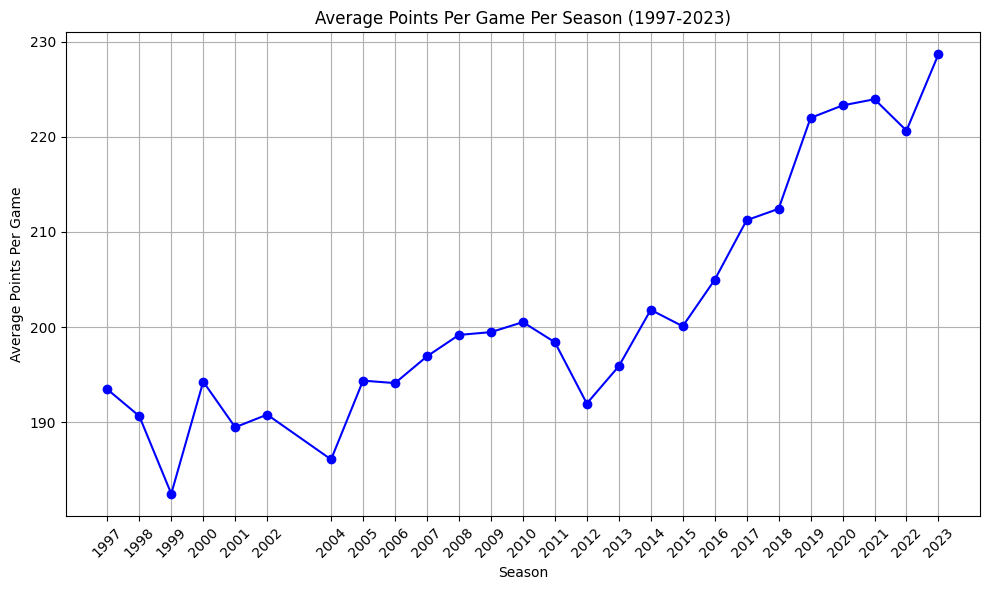

In [3]:
#Calculate the average points per game per season for each season
average_points_per_game_per_season = (data.groupby('season')['PTS'].mean()) * 2
average_points_per_game_per_season = average_points_per_game_per_season.loc[1997:2023]

#Create a plot to show PPG over time
plt.figure(figsize=(10, 6))
average_points_per_game_per_season.plot(marker='o', color='blue', linestyle='-')
plt.title('Average Points Per Game Per Season (1997-2023)')
plt.xlabel('Season')
plt.ylabel('Average Points Per Game')
plt.grid(True)
plt.xticks(average_points_per_game_per_season.index, rotation=45)
plt.tight_layout()
plt.show()

On average the points per game(ppg) has increased from 193 in 1997 to 229 in 2023. This is due to many factors according to many sources inside the NBA. One explanation is that simply the players are getting better and better as time goes on. Another potential explanation is that the NBA has become more and more offensively focused.

Looking into home court advantage:


Contingency Table:
       Home   Away
Win   19418  13368
Lose  13368  19418
P-value: 0.0


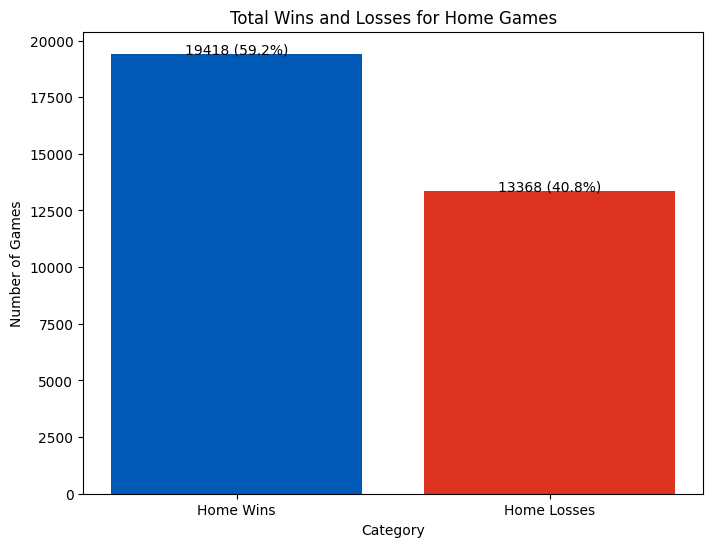

In [4]:
wins_df = data[data['win'] == 1]
total_wins = len(wins_df)
home_wins_df = wins_df[(wins_df['home'] == wins_df['team']) & (wins_df['win'] == 1)]
total_home_wins = len(home_wins_df)
total_home_loses = total_wins - total_home_wins
total_away_wins = total_home_loses
total_away_loses = total_home_wins
contingency_table = pd.DataFrame({
    'Home': [total_home_wins, total_home_loses],
    'Away': [total_away_wins, total_away_loses]
}, index=['Win', 'Lose'])
print("Contingency Table:")
print(contingency_table)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("P-value:", p_value)
categories = ['Home Wins', 'Home Losses']
values = [total_home_wins, total_home_loses]
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['#005AB5', '#DC3220'])
plt.xlabel('Category')
plt.ylabel('Number of Games')
plt.title('Total Wins and Losses for Home Games')
total_games = sum(values)
for bar, value in zip(bars, values):
    percentage = (value / total_games) * 100
    label = f"{value} ({percentage:.1f}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, label, ha='center', color='black')
plt.show()

Running a chi-squared test on whether or not home-court advantage is a real thing in the NBA produces a p-value of 0.00 so it is clear that we can reject the null hypothesis that being the home team does not increase your chances of winning the game.

Looking at number of turnovers:

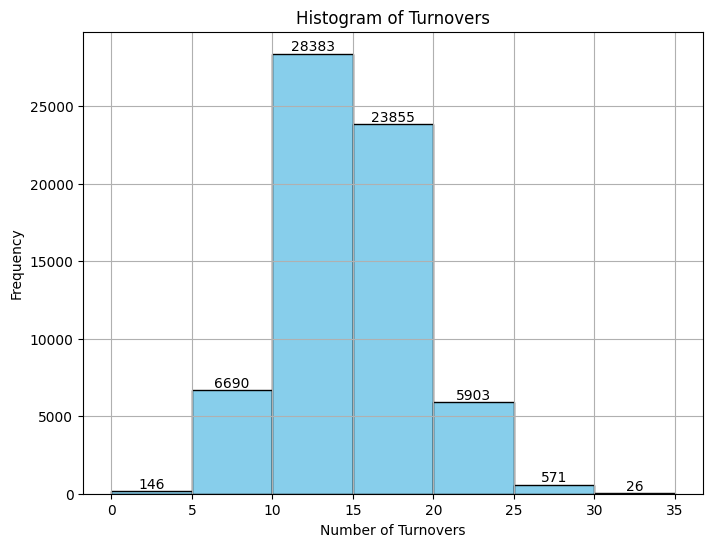

In [5]:
turnovers = data['TOV']
bin_edges = np.arange(0, int(max(turnovers)) + 6, 5)
plt.figure(figsize=(8, 6))
counts, bins, _ = plt.hist(turnovers, bins=bin_edges, color='skyblue', edgecolor='black')
plt.xlabel('Number of Turnovers')
plt.ylabel('Frequency')
plt.title('Histogram of Turnovers')
plt.grid(True)
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')
plt.show()

The histogram shows that there tends to be around 10-20 by a team during a game. Also looking at the data shows that no team has had 0 turnovers, with the lowest being 1 and the highest being 33.

These three conclusions lead me to believe that the number of turnovers in a game seem relatively standard, normally between 10-20 in a game. However, it is clear that having home court advantage has an affect on how likely a team is to win a game. Furthermore, from the line chart, the average points per game varies greatly from year to year so it is important when comparing to only look at a small timeframe. All of this leads me to focus in on the PPG of a team that season compared to the season average and whether or not the game is at home. I will then use classification machine learning algorithm to try and predict the winner of a given game.

## **Primary Analysis**

As mentioned previously, I will try and use a classification ML algorithm, given the PPG of a team that season and whether or not the game is at home to predict which team is most likely to win the game. I am using a classification algorithm since I am trying to predict/classify a certain game based on various given factors.

First, I create the PPG averages for each team for each season. Then I set up the feautres and the target variable. Then I split the dataset into training and testing sets, trained the model, and then evaluated it.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

team_season_avg_ppg = data.groupby(['season', 'team'])['PTS'].mean().reset_index()
data = data.merge(team_season_avg_ppg, how='left', on=['season', 'team'], suffixes=('', '_avg'))
data['home_advantage'] = (data['home'] == data['team']).astype(int)
features = data[['PTS_avg', 'home_advantage']]
target = data['win']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.5922988943957301
Confusion Matrix:
 [[3873 2679]
 [2668 3895]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      6552
         1.0       0.59      0.59      0.59      6563

    accuracy                           0.59     13115
   macro avg       0.59      0.59      0.59     13115
weighted avg       0.59      0.59      0.59     13115



While .592 accuarcy is not bad when predicting the result of a sports game, it is the same percentage as home court wins. This means that my model could just predict a win for any home game and not factor in any other data and have the same accuary; thus I am hoping to be able to improve the model such that its accuary is over .615.

To try and do this I will add the average number of turnovers that team has a season to the features the ML algorithm takes into account.

In [7]:
team_season_avg_tov = data.groupby(['season', 'team'])['TOV'].mean().reset_index()
data = data.merge(team_season_avg_tov, how='left', on=['season', 'team'], suffixes=('', '_avg_tov'))
features = data[['PTS_avg', 'home_advantage', 'TOV_avg_tov']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.5969500571864278
Confusion Matrix:
 [[3923 2629]
 [2657 3906]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      6552
         1.0       0.60      0.60      0.60      6563

    accuracy                           0.60     13115
   macro avg       0.60      0.60      0.60     13115
weighted avg       0.60      0.60      0.60     13115



While the accuary did improve to .597, I still hope that I can improve the algorithm further. I will now add the average FG% and rebound average to the features set.

In [8]:
team_season_avg_fg = data.groupby(['season', 'team'])['FG%'].mean().reset_index()
team_season_avg_reb = data.groupby(['season', 'team'])['REB'].mean().reset_index()
data = data.merge(team_season_avg_fg, how='left', on=['season', 'team'], suffixes=('', '_avg_fg'))
data = data.merge(team_season_avg_reb, how='left', on=['season', 'team'], suffixes=('', '_avg_reb'))
features = data[['PTS_avg', 'home_advantage', 'TOV_avg_tov', 'FG%_avg_fg', 'REB_avg_reb']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.6144872283644681
Confusion Matrix:
 [[4015 2537]
 [2519 4044]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      6552
         1.0       0.61      0.62      0.62      6563

    accuracy                           0.61     13115
   macro avg       0.61      0.61      0.61     13115
weighted avg       0.61      0.61      0.61     13115



This helped the algorithm reach .614 accurarcy but I want to see if I can make it even better. To do this I will try and standardize each feature. Standardization scales each feature to a mean of 0 and standard deviation of 1 while not altering the distribution shape; ensuring that features have comparable scales.


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.6145634769348075
Confusion Matrix:
 [[4011 2541]
 [2514 4049]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      6552
         1.0       0.61      0.62      0.62      6563

    accuracy                           0.61     13115
   macro avg       0.61      0.61      0.61     13115
weighted avg       0.61      0.61      0.61     13115



That only improved the model slightly, to an accuarcy of .615. Possibly it is because I am using a logistic regression model. To fix this I will try a Random Forest Classifier approach instead.

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Accuracy: 0.6262295081967213
Confusion Matrix:
 [[4078 2474]
 [2428 4135]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.62      0.62      6552
         1.0       0.63      0.63      0.63      6563

    accuracy                           0.63     13115
   macro avg       0.63      0.63      0.63     13115
weighted avg       0.63      0.63      0.63     13115



This improved the model's accuarcy to .626 much better than the original .592 of the first model.

## **Visualization**

Furthmore, since the model is switched to a Random Forest Classifier I can now look at the importance of each feature on predicting the result of the game.

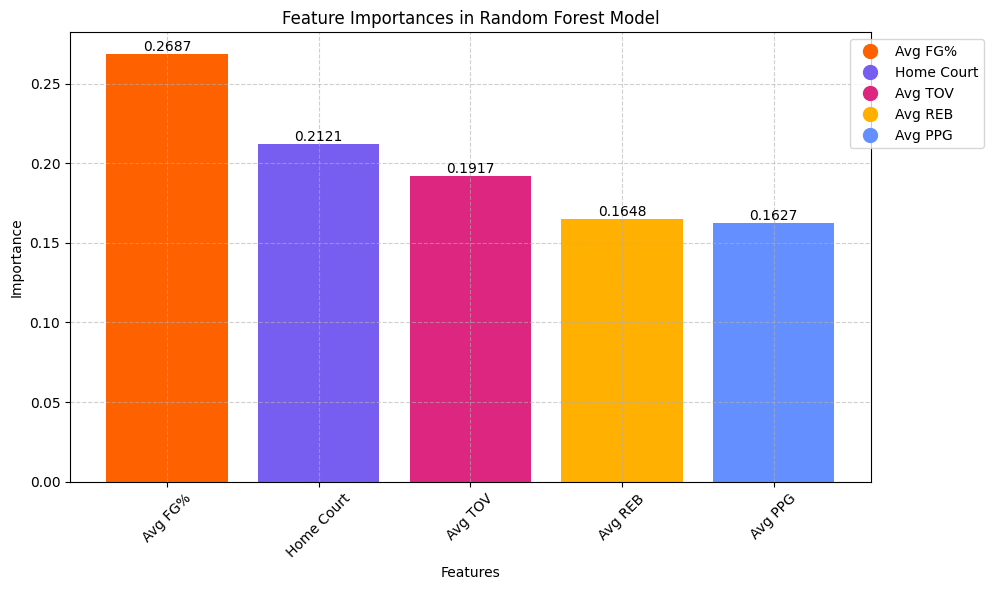

In [20]:
feature_names = ['Avg PPG', 'Home Court', 'Avg TOV', 'Avg FG%', 'Avg REB']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'] #Colorblind friendly colors
plt.figure(figsize=(10, 6))
plt.title('Feature Importances in Random Forest Model')
bars = plt.bar(range(len(importances)), importances[indices], color=[colors[i] for i in indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid(True, linestyle='--', alpha=0.6)
legend_patches = [plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='', markersize=10) for i in indices]
plt.legend(legend_patches, [feature_names[i] for i in indices], loc='upper right', bbox_to_anchor=(1.15, 1))
for bar, idx in zip(bars, indices):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

This bar chart highlights that the most important factor when it comes to predicting the result of a NBA game is the average FG% of the that team. The next important features (in order) are: home court advantage, average number of turnovers, average number of rebounds, and average points per game.

## **Insights and Conclusions**

This project highlights the main aspects of the data science pipeline. I found a dataset that I was interested in learning more about, cleaned the dataset, did exploratory research on certain variables, and then went through multiple iterations of different machine learning algorithms to try and best predict the result of a NBA game. This helped me become familiar with creating and testing different ML models. Speaking towards the result of the model, since the final version of the model is a Random Forest Classifier, it is possible to look at the importance of each feature in the model predicting the result of a game. The results surprised me, in particular that average points per game was the least important factor. Originally, I thought that average PPG or home court advantage would have been the largest factor; however, in the end, the largest factor was average FG% and home court advantage was the second most important factor. In conclusion, I was able to create a model that can predict with .626 accuarcy which team will win a NBA game based on season averages of FG%, turonvers, points per game, and rebounds, along with what team is playing at home.
